In [1]:
import jax
import jax.numpy as jnp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
from jax.example_libraries import optimizers
from jax.example_libraries.optimizers import adamax as optimizer
# jax.config.update('jax_platform_name', 'cpu')
# jax.config.update('jax_disable_jit', True)

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.50'

In [35]:
MB = 2 ** 8
NN_SHAPES = jnp.array([64, 64, 64, 64])
SCALE = 1e-3
INIT_KEYS = jax.random.split(jax.random.PRNGKey(1), 8)
LAMBDA = 0.

BETA = 0.8
MAX_AGE = 2.
MIN_DP = 0.2
INTEREST = 0.5
UTILITY_CONSTANT = 1.

R = (1 + INTEREST)
B = BETA
BR = B * R
OBJECTIVE_FN = lambda x, t: jax.lax.select((jnp.where(t == 1, size=1)[0] == 2)[0], 
                                           jnp.array([jnp.log(x), 
                                                      x, 
                                                      0., 
                                                      1.]), 
                                           jax.lax.select((jnp.where(t == 1, size=1)[0] == 1)[0], 
                                                          jnp.array([jnp.log((1 / (1 + B)) * x) + BETA * jnp.log(R * (1 - (1 / (1 + B))) * x), 
                                                                     (1 / (1 + B)) * x, 
                                                                     R * (1 - (1 / (1 + B))) * x, 
                                                                     1.]), 
                                                          jax.lax.select((jnp.where(t == 1, size=1)[0] == 0)[0],
                                                              jnp.array([jnp.log((1 / (1 + B + B**2)) * x) +\
                                                                         BETA * jnp.log((1 / (1 + B)) * R * (1 - (1 / (1 + B + B**2))) * x) +\
                                                                         BETA**2 * jnp.log(R * (B / (1 + B)) * R * (1 - (1 / (1 + B + B**2))) * x),
                                                                         ((1) / (1 + B + B**2)) * x,
                                                                         R * (1 - ((1) / (1 + B + B**2))) * x,
                                                                         1.]),
                                                              jnp.array([0., 0., 0., 1.]))))


all_X = jnp.concatenate((jnp.linspace(1e-5, 1., 1000), jnp.linspace(1e-5, 1., 1000), jnp.linspace(1e-5, 1., 1000),
                         jnp.linspace(1e-5, 1., 1000), jnp.linspace(1e-5, 1., 1000), jnp.linspace(1e-5, 1., 1000)))
all_T = jax.nn.one_hot(jnp.concatenate((jnp.zeros(1000), jnp.ones(1000), 2 * jnp.ones(1000),
                                        jnp.zeros(1000), jnp.ones(1000), 2 * jnp.ones(1000))), 4)
all_O = jnp.concatenate((jnp.ones(1000), jnp.ones(1000), jnp.ones(1000),
                         jnp.zeros(1000), jnp.zeros(1000), jnp.zeros(1000)))

In [36]:
initializer = jax.nn.initializers.glorot_normal()
w0 = SCALE * initializer(INIT_KEYS[0], (5, NN_SHAPES[0]), jnp.float32)
w1 = SCALE * initializer(INIT_KEYS[1], (NN_SHAPES[0], NN_SHAPES[1]), jnp.float32)
w2 = SCALE * initializer(INIT_KEYS[2], (NN_SHAPES[1], NN_SHAPES[2]), jnp.float32)
ow3 = SCALE * initializer(INIT_KEYS[3], (NN_SHAPES[2] + 5, NN_SHAPES[3]), jnp.float32)
rw3 = SCALE * initializer(INIT_KEYS[3], (NN_SHAPES[2] + 6, NN_SHAPES[3]), jnp.float32)
wf = SCALE * initializer(INIT_KEYS[4], (NN_SHAPES[3], 1), jnp.float32)
b0 = SCALE * initializer(INIT_KEYS[5], (1, NN_SHAPES[0]), jnp.float32)
b1 = SCALE * initializer(INIT_KEYS[6], (1, NN_SHAPES[1]), jnp.float32)
b2 = SCALE * initializer(INIT_KEYS[7], (1, NN_SHAPES[2]), jnp.float32)
b3 = SCALE * initializer(INIT_KEYS[8], (1, NN_SHAPES[3]), jnp.float32)
bf = SCALE * initializer(INIT_KEYS[9], (1, 1), jnp.float32)
owner_params0 = {'w0': w0, 'w1': w1, 'w2': w2, 'vw3': ow3, 'cw3': ow3, 'vwf': wf, 'cwf': wf, 
                 'b0': b0, 'b1': b1, 'b2': b2, 'vb3': b3, 'cb3': b3, 'vbf': bf, 'cbf': bf}

renter_params0 = {'w0': w0, 'w1': w1, 'w2': w2, 'vw3': rw3, 'cw3': ow3, 'vwf':wf, 'cwf': wf, 
                  'b0': b0, 'b1': b1, 'b2': b2, 'vb3': b3, 'cb3': b3, 'vbf': bf, 'cbf': bf}

params0 = {'owner': owner_params0, 'renter': renter_params0}

In [37]:
@jax.jit
def linear(X, w, b):
    return jnp.dot(X, w) + b


@jax.jit
def custom_value_fn(X, w, b):
    x = linear(X, w, b) / 100.
    return ((jnp.int32(x > 1) * (jnp.log(jnp.abs(x)) + 1)) +
           (jnp.int32(x < -1) * (-1 * (1/2)*jnp.power(x, 2) - (1/2))) +
           (jnp.int32(x <= 1) * jnp.int32(x >= -1) * x))


@jax.jit
def relu(X, w, b):
    return jnp.maximum(linear(X, w, b), 0)


@jax.jit
def selu(X, w, b):
    return jax.nn.selu(linear(X, w, b))


@jax.jit
def celu(X, w, b):
    return jax.nn.celu(linear(X, w, b))


@jax.jit
def elu(X, w, b):
    return jax.nn.elu(linear(X, w, b), 5)


@jax.jit
def cosine_output(X, w, b):
    return (jnp.cos(linear(X, w, b) / 1000) + 1) / 2


@jax.jit
def tanh_output(X, w, b):
    return (jax.nn.tanh(linear(X, w, b) / 1000) + 1) / 2


@jax.jit
def sigmoid_output(X, w, b):
    return jax.nn.sigmoid(linear(X, w, b) / 1e6)


@jax.jit
def increment_t(t):
    i = jnp.where(t == 1, size=1)[0]
    return t.at[i].set(0).at[i+1].set(1)


@jax.jit
def owner_policy(params, x, t):    
    l0 = jnp.concatenate((x[jnp.newaxis], t))
    l1 = relu(l0, params['w0'], params['b0'])
    l2 = jnp.squeeze(relu(l1, params['w1'], params['b1']))
    # l3 = jnp.squeeze(relu(l2, params['w2'], params['b2']))
    l3 = relu(jnp.concatenate((l0, l2)), params['cw3'], params['cb3'])
    
    cu = jnp.squeeze(x * sigmoid_output(l3, params['cwf'], params['cbf']))
    c = jax.lax.select((jnp.where(t == 1, size=1)[0][0] >= MAX_AGE), x, cu)
    
    vu = jnp.squeeze(custom_value_fn(l3, params['vwf'], params['vbf']))
    v = jax.lax.select((jnp.where(t == 1, size=1)[0][0] > MAX_AGE), jnp.zeros(1), vu[jnp.newaxis])
    
    return jnp.concatenate((v.reshape(-1), c.reshape(-1), (R * (x - c)).reshape(-1), jnp.ones(1)))


@jax.jit
def renter_policy(params, x, t):
    # po = jnp.int32(x >= MIN_DP) * jnp.int32((jnp.where(t == 1, size=1)[0] < MAX_AGE))
    
    l0 = jnp.concatenate((x[jnp.newaxis], t))
    l1 = selu(l0, params['w0'], params['b0'])
    l2 = selu(l1, params['w1'], params['b1'])
    l3 = jnp.squeeze(selu(l2, params['w2'], params['b2']))
    
    # cl0 = l0 # jnp.concatenate((l0, po))
    cl3 = selu(jnp.concatenate((l0, l3)), params['cw3'], params['cb3'])
    cu = x * sigmoid_output(cl3, params['cwf'], params['cbf'])
    c = jnp.select((jnp.where(t == 1, size=1)[0] >= MAX_AGE), x[jnp.newaxis], cu)
    
    o1 = jnp.squeeze(jnp.int32(x - c >= MIN_DP)) # If the agent saves enough they can become an owner
    
    vl0 = jnp.concatenate((l0, o1[jnp.newaxis]))
    vl3 = selu(jnp.concatenate((vl0, l3)), params['vw3'], params['vb3'])
    vu = custom_value_fn(vl3, params['vwf'], params['vbf'])
    v = jnp.select((jnp.where(t == 1, size=1)[0] > MAX_AGE), jnp.zeros(1), vu)
    
    return jnp.concatenate((v.reshape(-1), c.reshape(-1), ((1 + o1 * INTEREST) * (x - c)).reshape(-1), o1.reshape(-1)))


@jax.jit
def neural_network(params, x, t, o):
    return jax.lax.select((o == 1.), jnp.squeeze(owner_policy(params['owner'], x, t)), jnp.squeeze(renter_policy(params['renter'], x, t)))


@jax.jit
def loss(params, x, t, o):
    v0, c0, x1, o1 = neural_network(params, x, t, o)
    v1, c1, x2, o2 = neural_network(params, x1, increment_t(t), o1)
    
    vf = lambda params, x, t, o: neural_network(params, x, t, o)[0]
    v1r = vf(params, x1, increment_t(t), 0.)
    v1o = vf(params, x1, increment_t(t), 1.)
    v_diff = v1o - v1r
    
    c0x = jax.grad(lambda x: neural_network(params, x, t, o)[1])(x)
    v0x = jax.grad(vf, (1))(params, x, t, o)
    v1x = jax.grad(vf, (1))(params, x1, increment_t(t), o1)
    
    live_next = (jnp.where(t == 1, size=1)[0][0] < MAX_AGE)
    loss_euler = o * jax.lax.select(live_next ,(c1 - BR * c0), 0.)
    loss_bellman = ((UTILITY_CONSTANT * jnp.log(c0) + BETA * v1) - v0)
    loss_foc = jax.lax.select(live_next, BR * v1x  * c0 - 1, 0.)
    loss_envelope = (c0x - c0 * v0x)
    
    return jnp.array([loss_euler, loss_bellman, loss_foc, loss_envelope])


@jax.jit
def batch_loss(params, xs, ts, os, W=jnp.diag(jnp.ones(4))):
    losses = jax.vmap(loss, in_axes=(None, 0, 0, 0))(params, xs, ts, os)
    l2_penalty = jnp.sum(jnp.array([jnp.linalg.norm(v, ord=2) for k, v in params['owner'].items() if 'w' in k])) +\
                 jnp.sum(jnp.array([jnp.linalg.norm(v, ord=2) for k, v in params['renter'].items() if 'w' in k]))
    return jnp.sum(jax.vmap(lambda l: l @ W @ l.T)(losses)) + LAMBDA * l2_penalty, tuple((jnp.sum(losses[:, 0]**2), jnp.sum(losses[:, 1]**2), jnp.sum(losses[:, 2]**2), jnp.sum(losses[:, 3]**2)))

In [38]:
def training_loop(X, T, O, opt_state, opt_update, get_params, W=jnp.diag(jnp.ones(4)), max_iter=1000):
    j = 0
    key = jax.random.PRNGKey(1)
    keys = jax.random.split(key, max_iter)
    
    best_opt_state = opt_state
    best_loss, _ = batch_loss(get_params(best_opt_state), all_X, all_T, all_O)

    while j < max_iter:
        key = keys[j]
        sample = jax.random.choice(key, jnp.arange(X.shape[0]), (3, MB))
        params = get_params(opt_state)

        (val_loss, (loss_euler, loss_bellman, loss_foc, loss_envelope)), grad = jax.value_and_grad(batch_loss, has_aux=True)(get_params(opt_state), X[sample[0]], T[sample[1]], O[sample[2]], W=W)
        
        if any([jnp.isnan(v).any() for v in params.values()]) or any([jnp.isnan(v).any() for v in grad.values()]):
            print(f'Encountered a NaN in iteration {j}, terminating ...')
            print(params)
            print(grad)
            break
        
        opt_state = opt_update(j, grad, opt_state)
        
        if j == 0:
            start_time = time.time()
        
        j += 1
        if j % 100 == 0:
            fair_loss, _ = batch_loss(params, all_X, all_T, all_O)
            if val_loss < best_loss:
                best_opt_state = opt_state
                best_loss = fair_loss
            print(f'Iteration: {j}\tCurrent Loss: {val_loss:.2f}\tFair Loss: {fair_loss:.2f}\tAverage samples/s: {((MB * j) / (time.time() - start_time)):.2f}\n'
                  f'Loss Euler: {loss_euler:.2e}\tLoss Bellman: {loss_bellman:.2e}\tLoss FoC: {loss_foc:.2e}\tLoss Envelope: {loss_envelope:.2e}')
        
    return opt_state, best_opt_state

In [7]:
opt_init, opt_update, get_params = optimizer(step_size=1e-1)
init_opt_state = opt_init(params0)

X = jnp.linspace(1e-5, 1., 1000)
T = jax.nn.one_hot(jnp.concatenate((jnp.zeros(333), jnp.ones(333), 2 * jnp.ones(334))), 4)
O = jnp.ones(1000)
W = jnp.diag(jnp.array([1e1, 1., 0., 0.]))
if 'best_opt_state' not in globals():
    opt_state = init_opt_state
else:
    opt_state = best_opt_state

current_opt_state, best_opt_state = training_loop(X, T, O, opt_state, opt_update, get_params, W=W, max_iter=20000)
OWNER_PARAMS = get_params(best_opt_state)['owner']

Iteration: 100	Current Loss: 0.31	Fair Loss: 3.23	Average samples/s: 43153.50
Loss Euler: 7.93e-03	Loss Bellman: 2.32e-01	Loss FoC: 3.95e-01	Loss Envelope: 7.93e-01
Iteration: 200	Current Loss: 0.28	Fair Loss: 3.09	Average samples/s: 43881.22
Loss Euler: 8.06e-03	Loss Bellman: 2.00e-01	Loss FoC: 3.15e-01	Loss Envelope: 6.85e-01
Iteration: 300	Current Loss: 0.15	Fair Loss: 2.99	Average samples/s: 44084.70
Loss Euler: 7.87e-03	Loss Bellman: 7.63e-02	Loss FoC: 2.54e-01	Loss Envelope: 6.14e-01
Iteration: 400	Current Loss: 0.15	Fair Loss: 2.87	Average samples/s: 44339.88
Loss Euler: 8.28e-03	Loss Bellman: 6.84e-02	Loss FoC: 1.73e-01	Loss Envelope: 5.02e-01
Iteration: 500	Current Loss: 0.11	Fair Loss: 2.79	Average samples/s: 44343.07
Loss Euler: 8.28e-03	Loss Bellman: 2.39e-02	Loss FoC: 1.41e-01	Loss Envelope: 3.70e-01
Iteration: 600	Current Loss: 0.16	Fair Loss: 2.79	Average samples/s: 42587.37
Loss Euler: 7.69e-03	Loss Bellman: 7.93e-02	Loss FoC: 1.43e-01	Loss Envelope: 3.45e-01
Iteration:

Iteration: 5100	Current Loss: 0.09	Fair Loss: 2.70	Average samples/s: 24134.64
Loss Euler: 8.11e-03	Loss Bellman: 4.91e-03	Loss FoC: 1.08e-01	Loss Envelope: 2.54e-01
Iteration: 5200	Current Loss: 0.09	Fair Loss: 2.72	Average samples/s: 24104.19
Loss Euler: 8.08e-03	Loss Bellman: 8.72e-03	Loss FoC: 1.12e-01	Loss Envelope: 2.75e-01
Iteration: 5300	Current Loss: 0.09	Fair Loss: 2.72	Average samples/s: 24068.50
Loss Euler: 8.11e-03	Loss Bellman: 1.13e-02	Loss FoC: 1.16e-01	Loss Envelope: 2.75e-01
Iteration: 5400	Current Loss: 0.09	Fair Loss: 2.69	Average samples/s: 24045.90
Loss Euler: 8.12e-03	Loss Bellman: 7.65e-03	Loss FoC: 9.02e-02	Loss Envelope: 2.42e-01
Iteration: 5500	Current Loss: 0.08	Fair Loss: 2.69	Average samples/s: 24007.84
Loss Euler: 7.96e-03	Loss Bellman: 3.20e-03	Loss FoC: 1.04e-01	Loss Envelope: 2.57e-01
Iteration: 5600	Current Loss: 0.11	Fair Loss: 2.74	Average samples/s: 23974.84
Loss Euler: 8.21e-03	Loss Bellman: 2.62e-02	Loss FoC: 1.07e-01	Loss Envelope: 2.80e-01
Iter

Iteration: 10100	Current Loss: 0.04	Fair Loss: 2.68	Average samples/s: 23139.73
Loss Euler: 4.09e-03	Loss Bellman: 2.24e-03	Loss FoC: 6.57e-02	Loss Envelope: 2.49e-01
Iteration: 10200	Current Loss: 0.04	Fair Loss: 2.67	Average samples/s: 23126.02
Loss Euler: 3.78e-03	Loss Bellman: 1.50e-03	Loss FoC: 6.05e-02	Loss Envelope: 2.58e-01
Iteration: 10300	Current Loss: 0.04	Fair Loss: 2.67	Average samples/s: 23112.55
Loss Euler: 3.57e-03	Loss Bellman: 1.50e-03	Loss FoC: 6.28e-02	Loss Envelope: 2.59e-01
Iteration: 10400	Current Loss: 0.03	Fair Loss: 2.67	Average samples/s: 23101.52
Loss Euler: 3.10e-03	Loss Bellman: 1.73e-03	Loss FoC: 5.63e-02	Loss Envelope: 2.40e-01
Iteration: 10500	Current Loss: 0.03	Fair Loss: 2.67	Average samples/s: 23093.50
Loss Euler: 2.87e-03	Loss Bellman: 2.32e-03	Loss FoC: 5.41e-02	Loss Envelope: 2.52e-01
Iteration: 10600	Current Loss: 0.03	Fair Loss: 2.65	Average samples/s: 23085.63
Loss Euler: 2.44e-03	Loss Bellman: 1.59e-03	Loss FoC: 4.53e-02	Loss Envelope: 2.31e-0

Iteration: 15100	Current Loss: 0.00	Fair Loss: 2.59	Average samples/s: 22740.03
Loss Euler: 3.62e-06	Loss Bellman: 6.50e-04	Loss FoC: 1.24e-02	Loss Envelope: 1.98e-01
Iteration: 15200	Current Loss: 0.00	Fair Loss: 2.57	Average samples/s: 22732.25
Loss Euler: 3.19e-06	Loss Bellman: 1.63e-03	Loss FoC: 1.67e-02	Loss Envelope: 1.93e-01
Iteration: 15300	Current Loss: 0.00	Fair Loss: 2.58	Average samples/s: 22729.71
Loss Euler: 2.89e-06	Loss Bellman: 3.16e-03	Loss FoC: 1.37e-02	Loss Envelope: 1.91e-01
Iteration: 15400	Current Loss: 0.00	Fair Loss: 2.59	Average samples/s: 22731.60
Loss Euler: 2.95e-06	Loss Bellman: 1.87e-03	Loss FoC: 1.60e-02	Loss Envelope: 2.03e-01
Iteration: 15500	Current Loss: 0.00	Fair Loss: 2.58	Average samples/s: 22726.46
Loss Euler: 3.05e-06	Loss Bellman: 1.13e-03	Loss FoC: 1.90e-02	Loss Envelope: 2.05e-01
Iteration: 15600	Current Loss: 0.00	Fair Loss: 2.60	Average samples/s: 22721.56
Loss Euler: 2.63e-06	Loss Bellman: 1.34e-03	Loss FoC: 1.86e-02	Loss Envelope: 2.03e-0

In [10]:
params = get_params(best_opt_state)

init01 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params0, X, jnp.array([1., 0., 0., 0.]), 1.)
pred01 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, jnp.array([1., 0., 0., 0.]), 1.)
true01 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, jnp.array([1., 0., 0., 0.]))

init11 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params0, X, jnp.array([0., 1., 0., 0.]), 1.)
pred11 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, jnp.array([0., 1., 0., 0.]), 1.)
true11 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, jnp.array([0., 1., 0., 0.]))
                                                                 
init21 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params0, X, jnp.array([0., 0., 1., 0.]), 1.)
pred21 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, jnp.array([0., 0., 1., 0.]), 1.)
true21 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, jnp.array([0., 0., 1., 0.]))

                                                                 
df = pd.DataFrame(jnp.concatenate((X.reshape(-1, 1),
                                   init01, pred01, init11, pred11, init21, pred21,
                                   true01, true11, true21), 
                                  axis=1)).set_index(0)
df.columns = ['initial_v01', 'initial_c01', 'initial_x01', 'initial_o11', 'predicted_v01', 'predicted_c01', 'predicted_x01', 'predicted_o11',
              'initial_v11', 'initial_c11', 'initial_x11', 'initial_o21', 'predicted_v11', 'predicted_c11', 'predicted_x11', 'predicted_o21', 
              'initial_v21', 'initial_c21', 'initial_x21', 'initial_o31', 'predicted_v21', 'predicted_c21', 'predicted_x21', 'predicted_o31',
              'true_v01', 'true_c01', 'true_x01', 'true_011',
              'true_v11', 'true_c11', 'true_x11', 'true_021',
              'true_v21', 'true_c21', 'true_x21', 'true_031']

fig, axes = plt.subplots(3, 3, figsize=(16, 8))
df.plot(y=['predicted_v01'], ax=axes.flatten()[0])
df.plot(y=['predicted_v11'], ax=axes.flatten()[1])
df.plot(y=['predicted_v21'], ax=axes.flatten()[2])
df.plot(y=['predicted_c01'], ax=axes.flatten()[3])
df.plot(y=['predicted_c11'], ax=axes.flatten()[4])
df.plot(y=['predicted_c21'], ax=axes.flatten()[5])
df.plot(y=['predicted_x01'], ax=axes.flatten()[6])
df.plot(y=['predicted_x11'], ax=axes.flatten()[7])
df.plot(y=['predicted_x21'], ax=axes.flatten()[8])                                     
df.plot(y=['true_v01'], ax=axes.flatten()[0])
df.plot(y=['true_v11'], ax=axes.flatten()[1])
df.plot(y=['true_v21'], ax=axes.flatten()[2])
df.plot(y=['true_c01'], ax=axes.flatten()[3])
df.plot(y=['true_c11'], ax=axes.flatten()[4])
df.plot(y=['true_c21'], ax=axes.flatten()[5])
df.plot(y=['true_x01'], ax=axes.flatten()[6])
df.plot(y=['true_x11'], ax=axes.flatten()[7])
df.plot(y=['true_x21'], ax=axes.flatten()[8])
                                                   
for ax in axes.flatten()[6:8]:
    ax.axhline(y=MIN_DP, color='grey', linestyle='--', alpha=0.5)
    ax.axvline(x=MIN_DP, color='grey', linestyle='--', alpha=0.5)

KeyError: 'w0'

In [39]:
opt_state = optimizers.pack_optimizer_state(pickle.load(open('owner_only.pkl', 'rb')))
opt_init, opt_update, get_params = optimizer(step_size=1e-1)

params0 = get_params(opt_state)
OWNER_PARAMS = params0['owner']
params0 = {'owner': OWNER_PARAMS, 'renter': renter_params0}

In [40]:
@jax.jit
def neural_network(params, x, t, o):
    return jax.lax.select((o == 1.), jnp.squeeze(owner_policy(OWNER_PARAMS, x, t)), jnp.squeeze(renter_policy(params, x, t)))


@jax.jit
def batch_loss(params, xs, ts, os, W=jnp.diag(jnp.ones(4))):
    losses = jax.vmap(loss, in_axes=(None, 0, 0, 0))(params, xs, ts, os)
    # l2_penalty = jnp.sum(jnp.array([jnp.linalg.norm(v, ord=2) for k, v in params.items() if 'w' in k]))
    return jnp.sum(jax.vmap(lambda l: l @ W @ l.T)(losses)), tuple((jnp.sum(losses[:, 0]**2), jnp.sum(losses[:, 1]**2), jnp.sum(losses[:, 2]**2), jnp.sum(losses[:, 3]**2)))

In [41]:
opt_init, opt_update, get_params = optimizer(step_size=1.)
init_opt_state = opt_init(params0['renter'])

X = jnp.linspace(1e-5, 1., 1000)
T = jax.nn.one_hot(jnp.concatenate((jnp.zeros(333), jnp.ones(333), 2 * jnp.ones(334))), 4)
O = jnp.zeros(1000)
W = jnp.diag(jnp.array([0., 1., 1., 1.]))

if 'best_opt_state' not in globals():
    opt_state = init_opt_state
else:
    opt_state = opt_init(get_params(best_opt_state))

current_opt_state, best_opt_state = training_loop(X, T, O, opt_state, opt_update, get_params, W=W, max_iter=10000)

Iteration: 100	Current Loss: 32767.62	Fair Loss: 368929.44	Average samples/s: 2648.73
Loss Euler: 0.00e+00	Loss Bellman: 3.26e+04	Loss FoC: 9.24e+01	Loss Envelope: 1.05e+02
Iteration: 200	Current Loss: 27766.53	Fair Loss: 334320.00	Average samples/s: 2640.78
Loss Euler: 0.00e+00	Loss Bellman: 2.75e+04	Loss FoC: 1.28e+02	Loss Envelope: 1.11e+02
Iteration: 300	Current Loss: 30458.25	Fair Loss: 350712.12	Average samples/s: 2646.60
Loss Euler: 0.00e+00	Loss Bellman: 3.02e+04	Loss FoC: 1.09e+02	Loss Envelope: 1.09e+02
Iteration: 400	Current Loss: 30048.51	Fair Loss: 363355.19	Average samples/s: 2626.18
Loss Euler: 0.00e+00	Loss Bellman: 2.98e+04	Loss FoC: 1.07e+02	Loss Envelope: 1.04e+02
Iteration: 500	Current Loss: 32037.32	Fair Loss: 368875.97	Average samples/s: 2633.07
Loss Euler: 0.00e+00	Loss Bellman: 3.18e+04	Loss FoC: 9.82e+01	Loss Envelope: 1.17e+02
Iteration: 600	Current Loss: 32516.79	Fair Loss: 333708.12	Average samples/s: 2634.71
Loss Euler: 0.00e+00	Loss Bellman: 3.23e+04	Loss 

Iteration: 4900	Current Loss: 27753.95	Fair Loss: 324610.88	Average samples/s: 2622.37
Loss Euler: 0.00e+00	Loss Bellman: 2.75e+04	Loss FoC: 1.02e+02	Loss Envelope: 1.20e+02
Iteration: 5000	Current Loss: 30269.50	Fair Loss: 351405.69	Average samples/s: 2622.28
Loss Euler: 0.00e+00	Loss Bellman: 3.01e+04	Loss FoC: 1.04e+02	Loss Envelope: 9.91e+01
Iteration: 5100	Current Loss: 26354.47	Fair Loss: 296484.88	Average samples/s: 2622.10
Loss Euler: 0.00e+00	Loss Bellman: 2.61e+04	Loss FoC: 1.21e+02	Loss Envelope: 1.24e+02
Iteration: 5200	Current Loss: 24412.75	Fair Loss: 277756.12	Average samples/s: 2622.91
Loss Euler: 0.00e+00	Loss Bellman: 2.42e+04	Loss FoC: 1.01e+02	Loss Envelope: 1.33e+02
Iteration: 5300	Current Loss: 54862.53	Fair Loss: 616610.06	Average samples/s: 2624.18
Loss Euler: 0.00e+00	Loss Bellman: 5.47e+04	Loss FoC: 7.98e+01	Loss Envelope: 1.01e+02
Iteration: 5400	Current Loss: 51557.26	Fair Loss: 627569.12	Average samples/s: 2623.12
Loss Euler: 0.00e+00	Loss Bellman: 5.14e+04

Iteration: 9700	Current Loss: 25493.75	Fair Loss: 298540.84	Average samples/s: 2619.72
Loss Euler: 0.00e+00	Loss Bellman: 2.52e+04	Loss FoC: 1.21e+02	Loss Envelope: 2.02e+02
Iteration: 9800	Current Loss: 25435.95	Fair Loss: 298540.84	Average samples/s: 2619.60
Loss Euler: 0.00e+00	Loss Bellman: 2.51e+04	Loss FoC: 1.23e+02	Loss Envelope: 2.03e+02
Iteration: 9900	Current Loss: 23687.49	Fair Loss: 298540.84	Average samples/s: 2618.36
Loss Euler: 0.00e+00	Loss Bellman: 2.34e+04	Loss FoC: 1.30e+02	Loss Envelope: 2.04e+02
Iteration: 10000	Current Loss: 28961.12	Fair Loss: 298540.84	Average samples/s: 2618.22
Loss Euler: 0.00e+00	Loss Bellman: 2.86e+04	Loss FoC: 1.14e+02	Loss Envelope: 2.05e+02


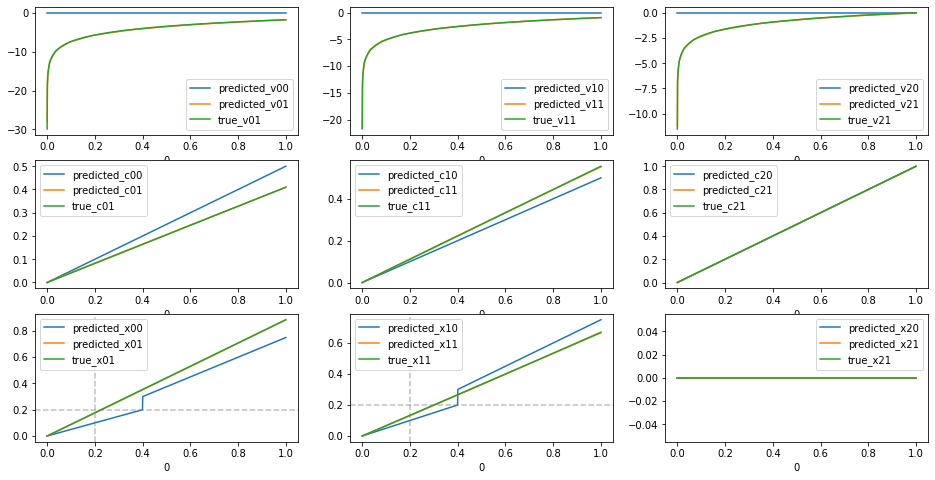

In [42]:
params = get_params(best_opt_state)

pred00 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, jnp.array([1., 0., 0., 0.]), 0.)
pred10 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, jnp.array([0., 1., 0., 0.]), 0.)
pred20 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, jnp.array([0., 0., 1., 0.]), 0.)
pred01 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, jnp.array([1., 0., 0., 0.]), 1.)
true01 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, jnp.array([1., 0., 0., 0.]))
pred11 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, jnp.array([0., 1., 0., 0.]), 1.)
true11 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, jnp.array([0., 1., 0., 0.]))
pred21 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, jnp.array([0., 0., 1., 0.]), 1.)
true21 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, jnp.array([0., 0., 1., 0.]))

                                                                 
df = pd.DataFrame(jnp.concatenate((X.reshape(-1, 1), 
                                   pred00, pred10, pred20,
                                   pred01, pred11, pred21,
                                   true01, true11, true21), 
                                  axis=1)).set_index(0)
df.columns = ['predicted_v00', 'predicted_c00', 'predicted_x00', 'predicted_o10',
              'predicted_v10', 'predicted_c10', 'predicted_x10', 'predicted_o20', 
              'predicted_v20', 'predicted_c20', 'predicted_x20', 'predicted_o30',
              'predicted_v01', 'predicted_c01', 'predicted_x01', 'predicted_o11',
              'predicted_v11', 'predicted_c11', 'predicted_x11', 'predicted_o21', 
              'predicted_v21', 'predicted_c21', 'predicted_x21', 'predicted_o31',
              'true_v01', 'true_c01', 'true_x01', 'true_011',
              'true_v11', 'true_c11', 'true_x11', 'true_021',
              'true_v21', 'true_c21', 'true_x21', 'true_031']

fig, axes = plt.subplots(3, 3, figsize=(16, 8))
df.plot(y=['predicted_v00'], ax=axes.flatten()[0])
df.plot(y=['predicted_v10'], ax=axes.flatten()[1])
df.plot(y=['predicted_v20'], ax=axes.flatten()[2])
df.plot(y=['predicted_v01'], ax=axes.flatten()[0])
df.plot(y=['predicted_v11'], ax=axes.flatten()[1])
df.plot(y=['predicted_v21'], ax=axes.flatten()[2])
df.plot(y=['predicted_c00'], ax=axes.flatten()[3])
df.plot(y=['predicted_c10'], ax=axes.flatten()[4])
df.plot(y=['predicted_c20'], ax=axes.flatten()[5])
df.plot(y=['predicted_c01'], ax=axes.flatten()[3])
df.plot(y=['predicted_c11'], ax=axes.flatten()[4])
df.plot(y=['predicted_c21'], ax=axes.flatten()[5])
df.plot(y=['predicted_x00'], ax=axes.flatten()[6])
df.plot(y=['predicted_x10'], ax=axes.flatten()[7])
df.plot(y=['predicted_x20'], ax=axes.flatten()[8])
df.plot(y=['predicted_x01'], ax=axes.flatten()[6])
df.plot(y=['predicted_x11'], ax=axes.flatten()[7])
df.plot(y=['predicted_x21'], ax=axes.flatten()[8])                                     
df.plot(y=['true_v01'], ax=axes.flatten()[0])
df.plot(y=['true_v11'], ax=axes.flatten()[1])
df.plot(y=['true_v21'], ax=axes.flatten()[2])
df.plot(y=['true_c01'], ax=axes.flatten()[3])
df.plot(y=['true_c11'], ax=axes.flatten()[4])
df.plot(y=['true_c21'], ax=axes.flatten()[5])
df.plot(y=['true_x01'], ax=axes.flatten()[6])
df.plot(y=['true_x11'], ax=axes.flatten()[7])
df.plot(y=['true_x21'], ax=axes.flatten()[8])
                                                   
for ax in axes.flatten()[6:8]:
    ax.axhline(y=MIN_DP, color='grey', linestyle='--', alpha=0.5)
    ax.axvline(x=MIN_DP, color='grey', linestyle='--', alpha=0.5)

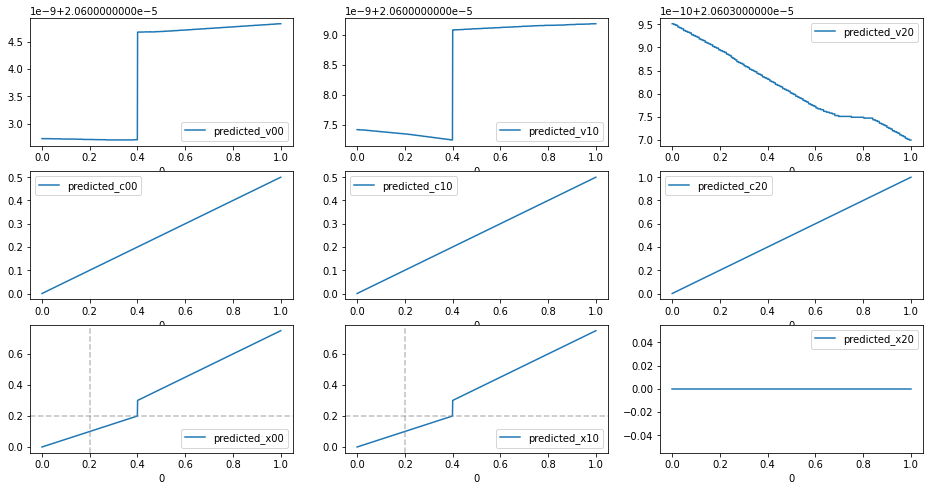

In [43]:
fig, axes = plt.subplots(3, 3, figsize=(16, 8))
df.plot(y=['predicted_v00'], ax=axes.flatten()[0])
df.plot(y=['predicted_v10'], ax=axes.flatten()[1])
df.plot(y=['predicted_v20'], ax=axes.flatten()[2])
df.plot(y=['predicted_c00'], ax=axes.flatten()[3])
df.plot(y=['predicted_c10'], ax=axes.flatten()[4])
df.plot(y=['predicted_c20'], ax=axes.flatten()[5])
df.plot(y=['predicted_x00'], ax=axes.flatten()[6])
df.plot(y=['predicted_x10'], ax=axes.flatten()[7])
df.plot(y=['predicted_x20'], ax=axes.flatten()[8])                                   
                                                   
for ax in axes.flatten()[6:8]:
    ax.axhline(y=MIN_DP, color='grey', linestyle='--', alpha=0.5)
    ax.axvline(x=MIN_DP, color='grey', linestyle='--', alpha=0.5)

In [17]:
@jax.jit
def outputs(params, x, t, o):
    v0, c0, x1, o1 = neural_network(params, x, t, o)
    v1, c1, x2, o2 = neural_network(params, x1, increment_t(t), o1)
    
    vf = lambda params, x, t, o: neural_network(params, x, t, o)[0]
    v1r = vf(params, x1, increment_t(t), 0.)
    v1o = vf(params, x1, increment_t(t), 1.)
    v_diff = v1o - v1r
    
    c0x = jax.grad(lambda x: neural_network(params, x, t, o)[1])(x)
    v0x = jax.grad(vf, (1))(params, x, t, o)
    v1x = jax.grad(vf, (1))(params, x1, increment_t(t), o1)
    return (v0, v1, c0, v0x, v1x, c0x)

params = get_params(best_opt_state)
v0s, v1s, c0s, v0xs, v1xs, c0xs = jax.vmap(outputs, in_axes=(None, 0, 0, 0))(params, all_X, all_T, all_O)

In [18]:
df = pd.DataFrame(jnp.concatenate((all_X.reshape(-1, 1), all_T, all_O.reshape(-1, 1), v0s.reshape(-1, 1), v1s.reshape(-1, 1), c0s.reshape(-1, 1), v0xs.reshape(-1, 1), v1xs.reshape(-1, 1), c0xs.reshape(-1, 1)), axis=1), columns=['X', 't0', 't1', 't2', 't3', 'O', 'v0', 'v1', 'c0', 'v0x', 'v1x', 'c0x'])

<AxesSubplot:xlabel='X'>

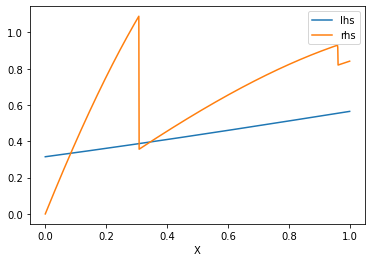

In [27]:
df['lhs'] = df['c0x']
df['rhs'] = df['c0'] * df['v0x']
df[(df['O'] == 0.) & (df['t0'] == 1.)].plot(x='X', y=['lhs', 'rhs'])

<AxesSubplot:xlabel='X'>

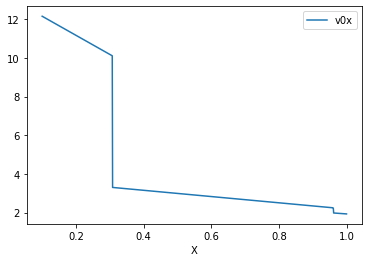

In [28]:
df[(df['O'] == 0.) & (df['t0'] == 1.) & (df['X'] > 0.1)].plot(x='X', y=['v0x'])

<AxesSubplot:xlabel='X'>

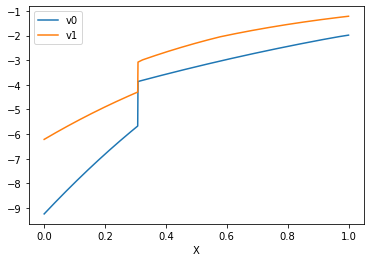

In [21]:
df[(df['O'] == 0.) & (df['t0'] == 1.)].plot(x='X', y=['v0', 'v1'])

<AxesSubplot:xlabel='X'>

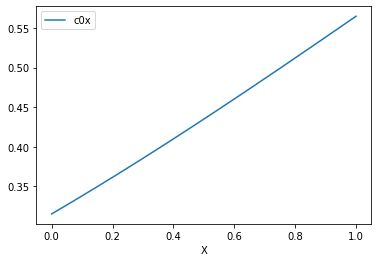

In [26]:
df[(df['O'] == 0.) & (df['t0'] == 1.)].plot(x='X', y='c0x')

In [97]:
trained_params = optimizers.unpack_optimizer_state(opt_init({'owner': OWNER_PARAMS, 'renter': get_params(best_opt_state)}))
pickle.dump(trained_params, open('owner_only.pkl', 'wb'))